In [1]:
import tensorflow as tf
print(tf.__version__)

2024-10-05 03:13:22.374062: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-05 03:13:22.395352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 03:13:22.412854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 03:13:22.417832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 03:13:22.430663: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [3]:
import numpy as numpy
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib


# Set up paths for images

In [5]:
data_dir = pathlib.Path('./images')
len(list(data_dir.glob('*/*.jpg')))

1711

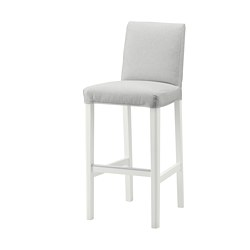

In [6]:
chairs = list(data_dir.glob('chair/*'))
PIL.Image.open(str(chairs[0]))

# Training / transfer learning model

In [7]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [8]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [9]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
batch_size = 64

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1371 images belonging to 4 classes.
Found 340 images belonging to 4 classes.


In [10]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 7, 7, 512)
(64, 512)


In [11]:
x = base_model.output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2*0.5)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=base_model.input, outputs=x)

In [12]:
base_learning_rate = 0.0001

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

model_2.summary()
      

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        16,38

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 119,562,244 (456.09 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
weights_file = 'vgg16_furniture_classifier_1129.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)


In [14]:
history = model_2.fit(
    train_generator,
    steps_per_epoch=3110 // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=772 // batch_size,
    verbose=1,
    callbacks=[checkpoint, early, tensorboard]
)


Epoch 1/15


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/48 ━━━━━━━━━━━━━━━━━━━━ 3:04 7s/step - accuracy: 0.7490 - loss: 5.6801

2024-10-04 17:02:29.438673: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to vgg16_furniture_classifier_1129.keras


2024-10-04 17:03:09.899655: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.8150 - loss: 4.2478 - val_accuracy: 0.9706 - val_loss: 0.5327
Epoch 2/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 3:00 7s/step - accuracy: 0.9876 - loss: 0.1806
Epoch 2: val_accuracy improved from 0.97059 to 0.98529, saving model to vgg16_furniture_classifier_1129.keras


2024-10-04 17:06:26.910995: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.9864 - loss: 0.2195 - val_accuracy: 0.9853 - val_loss: 0.1617
Epoch 3/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 2:59 7s/step - accuracy: 0.9866 - loss: 0.1122
Epoch 3: val_accuracy did not improve from 0.98529
48/48 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.9872 - loss: 0.1493 - val_accuracy: 0.9471 - val_loss: 1.0538
Epoch 4/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 2:59 7s/step - accuracy: 0.9857 - loss: 0.2245
Epoch 4: val_accuracy did not improve from 0.98529
48/48 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.9828 - loss: 0.3108 - val_accuracy: 0.9471 - val_loss: 0.8466
Epoch 5/15


2024-10-04 17:13:00.584698: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/48 ━━━━━━━━━━━━━━━━━━━━ 2:58 7s/step - accuracy: 0.9882 - loss: 0.1195
Epoch 5: val_accuracy did not improve from 0.98529
48/48 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.9890 - loss: 0.1083 - val_accuracy: 0.9676 - val_loss: 0.7820
Epoch 6/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 2:57 7s/step - accuracy: 0.9840 - loss: 0.4482
Epoch 6: val_accuracy did not improve from 0.98529
48/48 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.9860 - loss: 0.4115 - val_accuracy: 0.9676 - val_loss: 0.5049
Epoch 7/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 2:58 7s/step - accuracy: 0.9871 - loss: 0.2620
Epoch 7: val_accuracy did not improve from 0.98529
48/48 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.9842 - loss: 0.3367 - val_accuracy: 0.9324 - val_loss: 1.6202
Epoch 8/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 2:58 7s/step - accuracy: 0.9767 - loss: 0.3285
Epoch 8: val_accuracy improved from 0.98529 to 0.98824, saving model to vgg16_furniture_classifier_1129.keras


2024-10-04 17:25:45.433937: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.9795 - loss: 0.3154 - val_accuracy: 0.9882 - val_loss: 0.4908
Epoch 9/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 3:02 7s/step - accuracy: 0.9960 - loss: 0.2020
Epoch 9: val_accuracy did not improve from 0.98824
48/48 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.9954 - loss: 0.1998 - val_accuracy: 0.9676 - val_loss: 1.1128
Epoch 10/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 3:17 8s/step - accuracy: 0.9958 - loss: 0.0453
Epoch 10: val_accuracy did not improve from 0.98824
48/48 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.9949 - loss: 0.0724 - val_accuracy: 0.9824 - val_loss: 0.2170
Epoch 11/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 4:37 11s/step - accuracy: 0.9927 - loss: 0.1558
Epoch 11: val_accuracy did not improve from 0.98824
48/48 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - accuracy: 0.9931 - loss: 0.1535 - val_accuracy: 0.9765 - val_loss: 0.7024
Epoch 12/15
22/48 ━━━━━━━━━━━━━━━━━━━━ 4:43 11s/step - accuracy: 0.9963 - loss: 0.0500
Epoch 12: val_accuracy did not impro

# Plot Accuracy and loss of model

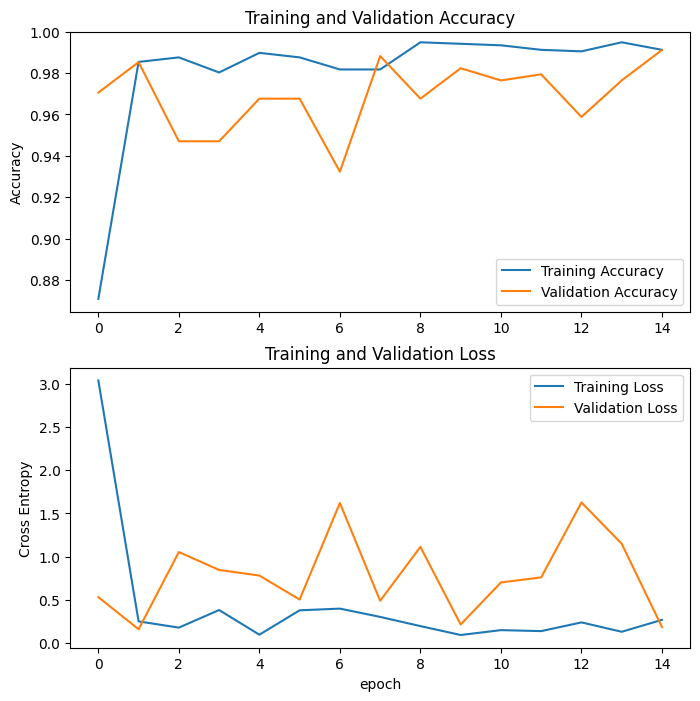

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Visualize Feature maps

In [16]:
from keras.preprocessing import image
preprocess_input = tf.keras.applications.vgg16.preprocess_input
from keras.models import Model
import numpy as np
from matplotlib import pyplot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


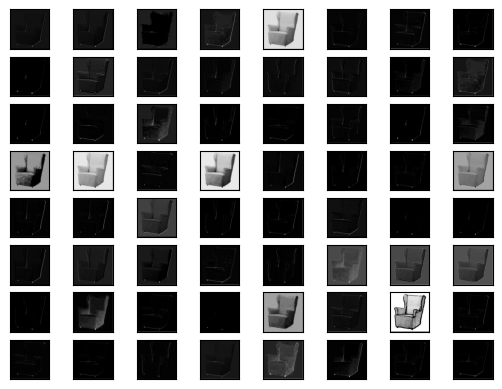

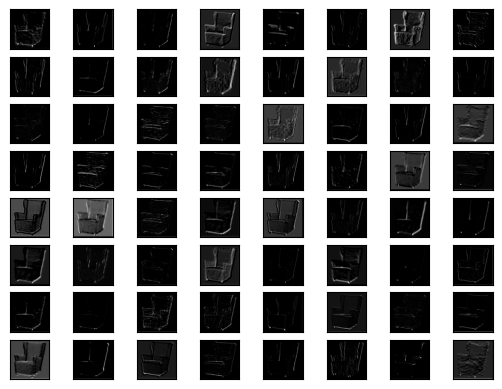

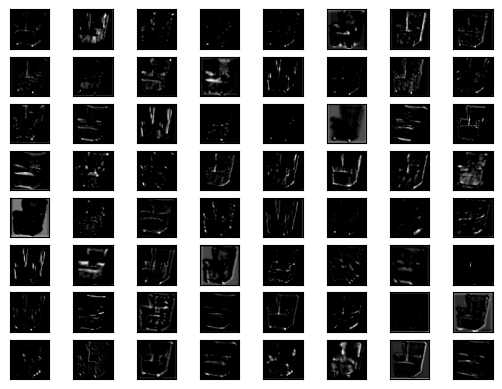

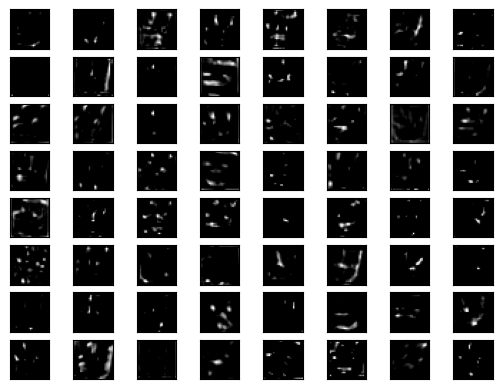

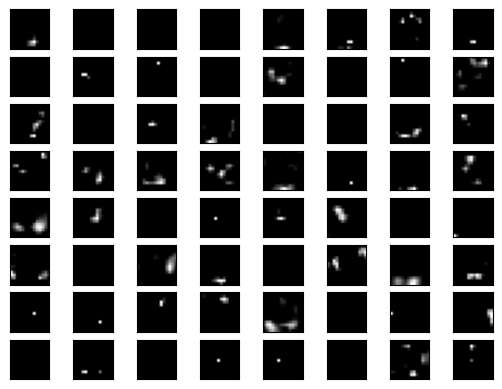

In [17]:
ixs = [2, 5, 9, 13, 17]
outputs = [model_2.layers[i].output for i in ixs]
model = Model(inputs=model_2.inputs, outputs=outputs)
img = image.load_img('./images/chair/199.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()

In [12]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Load the saved model
model_2 = load_model('vgg16_furniture_classifier_1129.keras')

# Prepare your image for classification
img_path = '../cropped_items/item_chair_7.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# Classify the image
predictions = model_2.predict(img_array)
predicted_index = np.argmax(predictions, axis=1)[0]

# Retrieve class names from the generator
data_dir = pathlib.Path('./images')
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

class_names = list(train_generator.class_indices.keys())  # Get the class names
predicted_class_name = class_names[predicted_index]

print("Predicted class index:", predicted_index)
print("Predicted class name:", predicted_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Found 1371 images belonging to 5 classes.
Predicted class index: 1
Predicted class name: chair
